Описание/Пошаговая инструкция выполнения домашнего задания:

- реализуйте алгоритм на основе политик А2С, DDPG;
- обучите агента в среде Car Racing;
- представьте исходный код, обученного агента и графики обучения агента.

PS: https://github.com/xtma/pytorch_car_caring/tree/master

In [24]:
import visdom

class DrawLine:

    def __init__(self, env, title, xlabel=None, ylabel=None):
        self.vis = visdom.Visdom()
        self.update_flag = False
        self.env = env
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title

    def __call__(
            self,
            xdata,
            ydata,
    ):
        if not self.update_flag:
            self.win = self.vis.line(
                X=np.array([xdata]),
                Y=np.array([ydata]),
                opts=dict(
                    xlabel=self.xlabel,
                    ylabel=self.ylabel,
                    title=self.title,
                ),
                env=self.env,
            )
            self.update_flag = True
        else:
            self.vis.line(
                X=np.array([xdata]),
                Y=np.array([ydata]),
                win=self.win,
                env=self.env,
                update='append',
            )

In [25]:
import argparse
import numpy as np
import gymnasium as gym
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

parser = argparse.ArgumentParser(description='Train a PPO agent for the CarRacing-v2')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G', help='discount factor (default: 0.99)')
parser.add_argument('--action-repeat', type=int, default=8, metavar='N', help='repeat action in N frames (default: 8)')
parser.add_argument('--img-stack', type=int, default=4, metavar='N', help='stack N image in a state (default: 4)')
parser.add_argument('--seed', type=int, default=0, metavar='N', help='random seed (default: 0)')
parser.add_argument('--render', default=False, action='store_true', help='render the environment')
parser.add_argument('--vis', default=False, action='store_true', help='use visdom')
parser.add_argument(
    '--log-interval', type=int, default=10, metavar='N', help='interval between training status logs (default: 10)')
args, unknown = parser.parse_known_args()

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [27]:
torch.manual_seed(args.seed)
if use_cuda:
    torch.cuda.manual_seed(args.seed)

transition = np.dtype([('s', np.float64, (args.img_stack, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (args.img_stack, 96, 96))])

class Env:
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, render_mode=None):
        self.env = gym.make('CarRacing-v2', render_mode)
        # self.env.seed(args.seed)
        self.reward_threshold = self.env.spec.reward_threshold

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb, info = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * args.img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(args.action_repeat):
            img_rgb, reward, die, truncated, _ = self.env.step(action)
            # don't penalize "die state"
            if die: # or truncated:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == args.img_stack
        return np.array(self.stack), total_reward, done, die

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            # normalize
            gray = gray / 128. - 1.
        return gray

    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

<img src="https://github.com/xtma/pytorch_car_caring/raw/master/img/network.png" width="400" />

In [28]:
class Net(nn.Module):
    """
    Actor-Critic Network for PPO
    """

    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(args.img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v


In [29]:
class Agent:
    """
    Agent for training
    """
    max_grad_norm = 0.5
    clip_param = 0.1  # epsilon in clipped loss
    ppo_epoch = 10
    buffer_capacity, batch_size = 2000, 128

    def __init__(self):
        self.training_step = 0
        self.net = Net().double().to(device)
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.counter = 0

        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def save_param(self):
        torch.save(self.net.state_dict(), 'target/ppo_net_params.pkl')

    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.buffer['s_'], dtype=torch.double).to(device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        with torch.no_grad():
            target_v = r + args.gamma * self.net(s_)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):
                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()


In [30]:
total_rewards = []  # total rewards to plot

if __name__ == "__main__":
    agent = Agent()
    env = Env()
    if args.vis:
        draw_reward = DrawLine(env="car", title="PPO", xlabel="Episode", ylabel="Moving averaged episode reward")

    best_running_score = -100
    running_score = 0
    state = env.reset()
    for i_ep in tqdm(range(2000)):
        score = 0
        state = env.reset()

        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            if args.render:
                env.render()
            if agent.store((state, action, a_logp, reward, state_)):
                print('updating')
                agent.update()
            score += reward
            state = state_
            if done or die:
                break

        running_score = running_score * 0.99 + score * 0.01
        total_rewards.append(score)  # add total reward to total rewards (will be used to plot)

        if i_ep % args.log_interval == 0:
            if args.vis:
                draw_reward(xdata=i_ep, ydata=running_score)
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
            if best_running_score < running_score:
                best_running_score = running_score
                print('Best running score: ' + str(best_running_score))
                agent.save_param()
        if running_score > env.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {}!".format(running_score, score))
            torch.save(agent.net.state_dict(), 'target/checkpoint-CarRacing-v2.pth')
            break

  0%|          | 1/2000 [00:21<11:40:18, 21.02s/it]

Ep 0	Last score: -17.90	Moving average score: -0.18
Best running score: -0.17895847750864996


  1%|          | 11/2000 [04:59<16:53:33, 30.58s/it]

Ep 10	Last score: -17.90	Moving average score: -2.05


  1%|          | 15/2000 [07:02<15:47:37, 28.64s/it]

updating


  1%|          | 21/2000 [09:43<14:53:50, 27.10s/it]

Ep 20	Last score: -17.92	Moving average score: -3.69


  2%|▏         | 31/2000 [14:15<17:14:11, 31.51s/it]

Ep 30	Last score: -17.92	Moving average score: -5.10
updating


  2%|▏         | 41/2000 [18:24<13:42:51, 25.20s/it]

Ep 40	Last score: -24.71	Moving average score: -6.49


  2%|▏         | 49/2000 [21:42<13:15:43, 24.47s/it]

updating


  3%|▎         | 51/2000 [23:08<19:04:37, 35.24s/it]

Ep 50	Last score: -39.44	Moving average score: -7.87


  3%|▎         | 61/2000 [28:06<16:29:13, 30.61s/it]

Ep 60	Last score: -18.07	Moving average score: -8.76


  3%|▎         | 63/2000 [28:53<14:25:25, 26.81s/it]

updating


  4%|▎         | 71/2000 [32:18<12:04:36, 22.54s/it]

Ep 70	Last score: -18.07	Moving average score: -9.77


  4%|▍         | 80/2000 [36:02<13:07:25, 24.61s/it]

updating


  4%|▍         | 81/2000 [36:28<13:26:56, 25.23s/it]

Ep 80	Last score: -18.08	Moving average score: -10.59


  5%|▍         | 91/2000 [40:31<13:14:28, 24.97s/it]

Ep 90	Last score: -20.53	Moving average score: -11.33


  5%|▍         | 97/2000 [43:29<14:43:44, 27.86s/it]

updating


  5%|▌         | 101/2000 [45:18<14:08:11, 26.80s/it]

Ep 100	Last score: -18.05	Moving average score: -12.00


  6%|▌         | 111/2000 [49:20<13:04:17, 24.91s/it]

Ep 110	Last score: -17.94	Moving average score: -12.13


  6%|▌         | 114/2000 [50:37<13:04:51, 24.97s/it]

updating


  6%|▌         | 121/2000 [53:42<13:43:08, 26.28s/it]

Ep 120	Last score: -17.98	Moving average score: -12.40


  7%|▋         | 131/2000 [58:01<13:02:23, 25.12s/it]

Ep 130	Last score: -17.99	Moving average score: -12.94
updating


  7%|▋         | 141/2000 [1:01:56<12:15:23, 23.74s/it]

Ep 140	Last score: -17.84	Moving average score: -13.07


  8%|▊         | 150/2000 [1:05:13<11:17:14, 21.96s/it]

updating


  8%|▊         | 151/2000 [1:05:41<12:11:51, 23.75s/it]

Ep 150	Last score: -17.81	Moving average score: -13.24


  8%|▊         | 161/2000 [1:09:51<12:21:37, 24.20s/it]

Ep 160	Last score: -17.92	Moving average score: -13.37


  8%|▊         | 166/2000 [1:12:39<16:05:31, 31.59s/it]

updating


  9%|▊         | 171/2000 [1:14:37<12:36:55, 24.83s/it]

Ep 170	Last score: -17.88	Moving average score: -13.17


  9%|▉         | 181/2000 [1:18:26<12:02:20, 23.83s/it]

Ep 180	Last score: -17.93	Moving average score: -12.37


  9%|▉         | 185/2000 [1:19:53<10:48:14, 21.43s/it]

updating


 10%|▉         | 191/2000 [1:22:28<13:44:27, 27.35s/it]

Ep 190	Last score: -22.45	Moving average score: -12.40


 10%|█         | 201/2000 [1:26:55<13:16:01, 26.55s/it]

Ep 200	Last score: -17.98	Moving average score: -12.11


 10%|█         | 202/2000 [1:27:16<12:28:55, 24.99s/it]

updating


 11%|█         | 211/2000 [1:30:38<10:25:57, 20.99s/it]

Ep 210	Last score: 18.40	Moving average score: -11.67


 11%|█         | 221/2000 [1:34:06<9:51:14, 19.94s/it] 

Ep 220	Last score: -18.02	Moving average score: -10.80


 11%|█         | 222/2000 [1:34:31<10:38:03, 21.53s/it]

updating


 12%|█▏        | 231/2000 [1:38:09<10:43:12, 21.82s/it]

Ep 230	Last score: 16.43	Moving average score: -9.79


 12%|█▏        | 241/2000 [1:41:53<11:32:12, 23.61s/it]

Ep 240	Last score: -18.07	Moving average score: -9.29


 12%|█▏        | 242/2000 [1:42:09<10:26:34, 21.38s/it]

updating


 13%|█▎        | 251/2000 [1:43:52<5:22:28, 11.06s/it] 

Ep 250	Last score: -18.00	Moving average score: -8.69


 13%|█▎        | 261/2000 [1:46:00<5:43:10, 11.84s/it]

Ep 260	Last score: -18.04	Moving average score: -7.72


 13%|█▎        | 262/2000 [1:46:13<5:48:55, 12.05s/it]

updating


 14%|█▎        | 271/2000 [1:47:46<5:11:10, 10.80s/it]

Ep 270	Last score: -18.01	Moving average score: -7.31


 14%|█▍        | 281/2000 [1:49:37<5:29:30, 11.50s/it]

Ep 280	Last score: -17.91	Moving average score: -6.48


 14%|█▍        | 284/2000 [1:50:07<4:50:03, 10.14s/it]

updating


 15%|█▍        | 291/2000 [1:51:36<5:54:28, 12.45s/it]

Ep 290	Last score: -18.07	Moving average score: -6.88


 15%|█▌        | 301/2000 [1:53:13<4:19:02,  9.15s/it]

Ep 300	Last score: 21.59	Moving average score: -5.89


 15%|█▌        | 305/2000 [1:54:08<6:01:47, 12.81s/it]

updating


 16%|█▌        | 311/2000 [1:55:08<5:05:39, 10.86s/it]

Ep 310	Last score: 26.61	Moving average score: -4.91


 16%|█▌        | 321/2000 [1:57:08<6:08:48, 13.18s/it]

Ep 320	Last score: -18.04	Moving average score: -4.59


 16%|█▋        | 327/2000 [1:58:11<5:00:13, 10.77s/it]

updating


 17%|█▋        | 331/2000 [1:58:56<4:46:30, 10.30s/it]

Ep 330	Last score: 15.15	Moving average score: -3.65


 17%|█▋        | 341/2000 [2:00:45<5:40:53, 12.33s/it]

Ep 340	Last score: -6.07	Moving average score: -1.88


 18%|█▊        | 351/2000 [2:02:22<3:50:13,  8.38s/it]

Ep 350	Last score: 13.41	Moving average score: -1.14
updating


 18%|█▊        | 361/2000 [2:03:57<4:06:45,  9.03s/it]

Ep 360	Last score: 16.73	Moving average score: 0.23
Best running score: 0.22596023825237738


 19%|█▊        | 371/2000 [2:05:43<4:44:47, 10.49s/it]

Ep 370	Last score: 20.59	Moving average score: 1.91
Best running score: 1.9106451930473298


 19%|█▉        | 376/2000 [2:06:26<4:11:10,  9.28s/it]

updating


 19%|█▉        | 381/2000 [2:07:17<4:04:02,  9.04s/it]

Ep 380	Last score: 34.64	Moving average score: 2.84
Best running score: 2.8355351462833496


 20%|█▉        | 391/2000 [2:08:36<3:44:48,  8.38s/it]

Ep 390	Last score: 16.31	Moving average score: 4.14
Best running score: 4.13543510436697


 20%|██        | 401/2000 [2:10:02<4:02:03,  9.08s/it]

Ep 400	Last score: -18.03	Moving average score: 4.63
Best running score: 4.629322757707195


 20%|██        | 404/2000 [2:10:29<4:04:12,  9.18s/it]

updating


 21%|██        | 411/2000 [2:11:28<3:49:38,  8.67s/it]

Ep 410	Last score: 22.49	Moving average score: 4.34


 21%|██        | 421/2000 [2:13:51<6:49:13, 15.55s/it]

Ep 420	Last score: -17.95	Moving average score: 5.68
Best running score: 5.684680169468677


 22%|██▏       | 430/2000 [2:16:49<7:15:47, 16.65s/it]

updating


 22%|██▏       | 431/2000 [2:17:19<8:57:54, 20.57s/it]

Ep 430	Last score: 19.75	Moving average score: 6.44
Best running score: 6.436402321200268


 22%|██▏       | 441/2000 [2:19:42<6:17:57, 14.55s/it]

Ep 440	Last score: 19.05	Moving average score: 8.28
Best running score: 8.284364641495559


 23%|██▎       | 451/2000 [2:22:00<5:13:05, 12.13s/it]

Ep 450	Last score: 8.93	Moving average score: 9.29
Best running score: 9.290526669706967


 23%|██▎       | 461/2000 [2:24:35<8:07:41, 19.01s/it]

Ep 460	Last score: 41.71	Moving average score: 10.48
Best running score: 10.483462733464313
updating


 24%|██▎       | 471/2000 [2:26:43<5:47:18, 13.63s/it]

Ep 470	Last score: 27.27	Moving average score: 11.68
Best running score: 11.681602871486389


 24%|██▍       | 481/2000 [2:28:35<4:02:15,  9.57s/it]

Ep 480	Last score: 16.23	Moving average score: 12.44
Best running score: 12.435175854943733


 25%|██▍       | 491/2000 [2:30:30<4:42:37, 11.24s/it]

Ep 490	Last score: 36.06	Moving average score: 13.13
Best running score: 13.128109271542256


 25%|██▍       | 496/2000 [2:32:05<6:22:42, 15.27s/it]

updating


 25%|██▌       | 501/2000 [2:33:20<5:57:12, 14.30s/it]

Ep 500	Last score: 15.56	Moving average score: 14.01
Best running score: 14.011075233843854


 26%|██▌       | 511/2000 [2:35:37<5:58:50, 14.46s/it]

Ep 510	Last score: 46.08	Moving average score: 14.39
Best running score: 14.394634400791363


 26%|██▌       | 521/2000 [2:37:36<4:48:10, 11.69s/it]

Ep 520	Last score: 16.39	Moving average score: 15.10
Best running score: 15.100331268978298


 26%|██▋       | 530/2000 [2:39:39<6:42:56, 16.45s/it]

updating


 27%|██▋       | 531/2000 [2:39:54<6:34:24, 16.11s/it]

Ep 530	Last score: 29.66	Moving average score: 15.43
Best running score: 15.432695958068894


 27%|██▋       | 541/2000 [2:42:36<6:32:35, 16.14s/it]

Ep 540	Last score: 31.67	Moving average score: 16.76
Best running score: 16.762892343710135


 28%|██▊       | 551/2000 [2:45:24<5:40:05, 14.08s/it]

Ep 550	Last score: 20.27	Moving average score: 17.22
Best running score: 17.217411207129185


 28%|██▊       | 559/2000 [2:47:10<5:49:58, 14.57s/it]

updating


 28%|██▊       | 561/2000 [2:47:40<5:46:19, 14.44s/it]

Ep 560	Last score: 17.27	Moving average score: 18.40
Best running score: 18.39904716116511


 29%|██▊       | 571/2000 [2:50:09<5:15:11, 13.23s/it]

Ep 570	Last score: 26.74	Moving average score: 18.94
Best running score: 18.943524230516626


 29%|██▉       | 581/2000 [2:52:22<5:03:33, 12.84s/it]

Ep 580	Last score: 44.49	Moving average score: 19.87
Best running score: 19.872336679606963


 30%|██▉       | 591/2000 [2:54:34<4:42:09, 12.02s/it]

Ep 590	Last score: 16.82	Moving average score: 19.98
Best running score: 19.977847174509037


 30%|██▉       | 592/2000 [2:54:49<5:06:29, 13.06s/it]

updating


 30%|███       | 601/2000 [2:57:00<4:46:42, 12.30s/it]

Ep 600	Last score: 11.95	Moving average score: 19.47


 31%|███       | 611/2000 [2:59:48<7:34:40, 19.64s/it]

Ep 610	Last score: 24.19	Moving average score: 20.69
Best running score: 20.691781609286792


 31%|███       | 620/2000 [3:02:25<6:03:41, 15.81s/it]

updating


 31%|███       | 621/2000 [3:02:45<6:36:58, 17.27s/it]

Ep 620	Last score: 53.23	Moving average score: 22.39
Best running score: 22.388629259777847


 32%|███▏      | 631/2000 [3:04:40<3:44:40,  9.85s/it]

Ep 630	Last score: 19.96	Moving average score: 22.76
Best running score: 22.764083768660882


 32%|███▏      | 641/2000 [3:07:47<5:50:07, 15.46s/it]

Ep 640	Last score: 24.11	Moving average score: 24.31
Best running score: 24.31367347991972


 32%|███▏      | 649/2000 [3:09:45<6:29:21, 17.29s/it]

updating


 33%|███▎      | 651/2000 [3:10:30<7:14:03, 19.31s/it]

Ep 650	Last score: 14.45	Moving average score: 24.67
Best running score: 24.668997950635045


 33%|███▎      | 661/2000 [3:14:51<8:00:56, 21.55s/it] 

Ep 660	Last score: 56.09	Moving average score: 26.61
Best running score: 26.613094660233063


 34%|███▎      | 671/2000 [3:17:19<5:26:23, 14.74s/it]

Ep 670	Last score: 23.17	Moving average score: 26.40


 34%|███▎      | 672/2000 [3:17:30<5:01:52, 13.64s/it]

updating


 34%|███▍      | 681/2000 [3:19:45<5:02:04, 13.74s/it]

Ep 680	Last score: 28.94	Moving average score: 27.94
Best running score: 27.94031290013478


 35%|███▍      | 691/2000 [3:24:19<9:00:02, 24.75s/it] 

Ep 690	Last score: 13.06	Moving average score: 31.39
Best running score: 31.387827109374804


 35%|███▍      | 693/2000 [3:24:43<6:45:25, 18.61s/it]

updating


 35%|███▌      | 701/2000 [3:28:21<11:48:44, 32.74s/it]

Ep 700	Last score: 56.09	Moving average score: 32.14
Best running score: 32.13841283476477


 36%|███▌      | 711/2000 [3:31:24<6:02:09, 16.86s/it] 

Ep 710	Last score: 36.40	Moving average score: 33.00
Best running score: 33.0046854257268
updating


 36%|███▌      | 721/2000 [3:38:01<8:56:34, 25.17s/it] 

Ep 720	Last score: 52.76	Moving average score: 36.55
Best running score: 36.54802659545384


 36%|███▋      | 728/2000 [3:39:58<5:36:35, 15.88s/it]

updating


 37%|███▋      | 731/2000 [3:41:14<6:49:33, 19.36s/it]

Ep 730	Last score: 12.76	Moving average score: 37.59
Best running score: 37.59268328192055


 37%|███▋      | 741/2000 [3:48:01<12:50:19, 36.71s/it]

Ep 740	Last score: 56.02	Moving average score: 43.81
Best running score: 43.80587220956698
updating


 38%|███▊      | 751/2000 [3:52:20<7:49:40, 22.56s/it] 

Ep 750	Last score: 56.08	Moving average score: 44.39
Best running score: 44.38743519006665


 38%|███▊      | 754/2000 [3:54:47<12:59:08, 37.52s/it]

updating


 38%|███▊      | 761/2000 [3:59:14<13:45:29, 39.98s/it]

Ep 760	Last score: 56.03	Moving average score: 50.38
Best running score: 50.37644635282816


 38%|███▊      | 766/2000 [4:02:25<12:17:46, 35.87s/it]

updating


 39%|███▊      | 771/2000 [4:06:06<12:49:45, 37.58s/it]

Ep 770	Last score: 56.03	Moving average score: 55.50
Best running score: 55.497277074069665


 39%|███▉      | 778/2000 [4:10:43<14:18:32, 42.15s/it]

updating


 39%|███▉      | 781/2000 [4:13:03<13:33:29, 40.04s/it]

Ep 780	Last score: 48.64	Moving average score: 61.96
Best running score: 61.95983278208307


 39%|███▉      | 786/2000 [4:18:26<18:58:32, 56.27s/it]

updating


 40%|███▉      | 791/2000 [4:22:37<14:12:13, 42.29s/it]

Ep 790	Last score: 31.92	Moving average score: 82.18
Best running score: 82.18381693363638


 40%|███▉      | 795/2000 [4:25:36<14:55:36, 44.59s/it]

updating


 40%|████      | 801/2000 [4:28:35<7:53:51, 23.71s/it] 

Ep 800	Last score: 38.95	Moving average score: 93.78
Best running score: 93.7811433319756


 40%|████      | 806/2000 [4:33:49<19:04:47, 57.53s/it]

updating


 41%|████      | 811/2000 [4:38:33<19:55:52, 60.35s/it]

Ep 810	Last score: 671.80	Moving average score: 120.96
Best running score: 120.96376161430004


 41%|████      | 815/2000 [4:41:16<15:03:03, 45.72s/it]

updating


 41%|████      | 821/2000 [4:48:33<22:50:11, 69.73s/it]

Ep 820	Last score: 724.80	Moving average score: 156.63
Best running score: 156.62793351505874


 41%|████      | 822/2000 [4:49:19<20:28:04, 62.55s/it]

updating


 42%|████▏     | 830/2000 [4:57:19<19:05:32, 58.75s/it]

updating


 42%|████▏     | 831/2000 [4:57:56<16:56:59, 52.20s/it]

Ep 830	Last score: 326.43	Moving average score: 178.48
Best running score: 178.47617465490248


 42%|████▏     | 839/2000 [5:04:29<14:57:24, 46.38s/it]

updating


 42%|████▏     | 841/2000 [5:06:08<15:15:57, 47.42s/it]

Ep 840	Last score: 405.62	Moving average score: 204.17
Best running score: 204.16650872774474


 42%|████▏     | 847/2000 [5:11:59<18:18:29, 57.16s/it]

updating


 43%|████▎     | 851/2000 [5:15:34<17:40:10, 55.36s/it]

Ep 850	Last score: 727.27	Moving average score: 234.63
Best running score: 234.62930285121777


 43%|████▎     | 858/2000 [5:20:08<10:29:48, 33.09s/it]

updating


 43%|████▎     | 861/2000 [5:23:03<15:53:31, 50.23s/it]

Ep 860	Last score: 737.58	Moving average score: 255.12
Best running score: 255.12472733144494


 43%|████▎     | 865/2000 [5:27:39<20:20:26, 64.52s/it]

updating


 44%|████▎     | 871/2000 [5:33:23<18:19:55, 58.46s/it]

Ep 870	Last score: 725.53	Moving average score: 292.03
Best running score: 292.0305779089491


 44%|████▎     | 873/2000 [5:35:53<21:07:12, 67.46s/it]

updating


 44%|████▍     | 880/2000 [5:42:50<20:31:59, 66.00s/it]

updating


 44%|████▍     | 881/2000 [5:44:07<21:34:23, 69.40s/it]

Ep 880	Last score: 722.20	Moving average score: 326.44
Best running score: 326.43770024215115


 44%|████▍     | 888/2000 [5:50:45<17:52:27, 57.87s/it]

updating


 45%|████▍     | 891/2000 [5:54:07<19:34:05, 63.52s/it]

Ep 890	Last score: 775.57	Moving average score: 361.50
Best running score: 361.50121040533026


 45%|████▍     | 897/2000 [5:59:24<16:53:54, 55.15s/it]

updating


 45%|████▌     | 901/2000 [6:03:37<18:35:58, 60.93s/it]

Ep 900	Last score: 724.57	Moving average score: 384.82
Best running score: 384.8160550965552


 45%|████▌     | 904/2000 [6:07:06<20:32:23, 67.47s/it]

updating


 46%|████▌     | 911/2000 [6:13:06<16:35:50, 54.87s/it]

Ep 910	Last score: 749.46	Moving average score: 407.55
Best running score: 407.55194432575786


 46%|████▌     | 912/2000 [6:13:44<15:02:10, 49.75s/it]

updating


 46%|████▌     | 921/2000 [6:20:14<11:29:22, 38.33s/it]

Ep 920	Last score: 85.40	Moving average score: 408.53
Best running score: 408.53007819038817


 46%|████▌     | 923/2000 [6:21:32<12:12:32, 40.81s/it]

updating


 47%|████▋     | 931/2000 [6:28:38<14:24:53, 48.54s/it]

Ep 930	Last score: 353.34	Moving average score: 415.44
Best running score: 415.44072951985476


 47%|████▋     | 933/2000 [6:29:39<11:46:25, 39.72s/it]

updating


 47%|████▋     | 941/2000 [6:37:18<16:49:30, 57.20s/it]

Ep 940	Last score: 786.51	Moving average score: 436.07
Best running score: 436.0712017964476


 47%|████▋     | 942/2000 [6:37:56<15:07:14, 51.45s/it]

updating


 48%|████▊     | 950/2000 [6:45:11<15:53:11, 54.47s/it]

updating


 48%|████▊     | 951/2000 [6:46:23<17:21:32, 59.57s/it]

Ep 950	Last score: 746.92	Moving average score: 450.71
Best running score: 450.7057721792181


 48%|████▊     | 957/2000 [6:53:15<19:29:34, 67.28s/it]

updating


 48%|████▊     | 961/2000 [6:57:02<17:04:14, 59.15s/it]

Ep 960	Last score: 779.43	Moving average score: 476.46
Best running score: 476.46343007653866


 48%|████▊     | 965/2000 [7:01:00<17:13:21, 59.91s/it]

updating


 49%|████▊     | 971/2000 [7:06:27<16:34:07, 57.97s/it]

Ep 970	Last score: 737.24	Moving average score: 495.12
Best running score: 495.11626611438646


 49%|████▉     | 975/2000 [7:08:52<11:19:08, 39.75s/it]

updating


 49%|████▉     | 981/2000 [7:14:34<16:14:35, 57.39s/it]

Ep 980	Last score: 723.69	Moving average score: 501.91
Best running score: 501.91164082015075


 49%|████▉     | 984/2000 [7:16:27<11:23:18, 40.35s/it]

updating


 50%|████▉     | 991/2000 [7:21:38<13:47:58, 49.24s/it]

Ep 990	Last score: 749.93	Moving average score: 500.71


 50%|████▉     | 994/2000 [7:24:01<13:58:15, 50.00s/it]

updating


 50%|█████     | 1001/2000 [7:30:16<13:26:16, 48.42s/it]

Ep 1000	Last score: 587.90	Moving average score: 513.79
Best running score: 513.7906327065841


 50%|█████     | 1003/2000 [7:31:54<13:50:11, 49.96s/it]

updating


 51%|█████     | 1011/2000 [7:38:43<13:17:24, 48.38s/it]

Ep 1010	Last score: 806.60	Moving average score: 521.36
Best running score: 521.3560231023563


 51%|█████     | 1012/2000 [7:39:48<14:40:25, 53.47s/it]

updating


 51%|█████     | 1021/2000 [7:47:30<15:03:41, 55.38s/it]

Ep 1020	Last score: 754.30	Moving average score: 529.18
Best running score: 529.1751554772811
updating


 52%|█████▏    | 1030/2000 [7:55:17<15:23:53, 57.15s/it]

updating


 52%|█████▏    | 1031/2000 [7:55:35<12:14:37, 45.49s/it]

Ep 1030	Last score: 56.04	Moving average score: 519.84


 52%|█████▏    | 1039/2000 [8:02:49<16:12:17, 60.71s/it]

updating


 52%|█████▏    | 1041/2000 [8:04:27<14:24:18, 54.08s/it]

Ep 1040	Last score: 574.29	Moving average score: 529.62
Best running score: 529.6248425645977


 52%|█████▏    | 1048/2000 [8:10:17<12:02:52, 45.56s/it]

updating


 53%|█████▎    | 1051/2000 [8:12:19<11:12:20, 42.51s/it]

Ep 1050	Last score: 414.19	Moving average score: 536.04
Best running score: 536.0381101155923


 53%|█████▎    | 1059/2000 [8:18:10<11:31:55, 44.12s/it]

updating


 53%|█████▎    | 1061/2000 [8:20:02<13:04:24, 50.12s/it]

Ep 1060	Last score: 743.65	Moving average score: 542.77
Best running score: 542.7715120019868


 53%|█████▎    | 1068/2000 [8:25:32<12:39:31, 48.90s/it]

updating


 54%|█████▎    | 1071/2000 [8:27:36<11:05:09, 42.96s/it]

Ep 1070	Last score: 339.57	Moving average score: 546.97
Best running score: 546.9730958135715


 54%|█████▍    | 1078/2000 [8:33:24<12:34:07, 49.08s/it]

updating


 54%|█████▍    | 1081/2000 [8:35:57<12:28:31, 48.87s/it]

Ep 1080	Last score: 557.37	Moving average score: 555.99
Best running score: 555.9885266095623


 54%|█████▍    | 1087/2000 [8:40:35<12:34:40, 49.60s/it]

updating


 55%|█████▍    | 1091/2000 [8:43:37<10:45:31, 42.61s/it]

Ep 1090	Last score: 56.09	Moving average score: 547.15


 55%|█████▍    | 1098/2000 [8:48:48<10:46:05, 42.98s/it]

updating


 55%|█████▌    | 1101/2000 [8:50:52<10:21:33, 41.48s/it]

Ep 1100	Last score: 788.02	Moving average score: 548.02


 55%|█████▌    | 1109/2000 [8:56:27<9:55:54, 40.13s/it] 

updating


 56%|█████▌    | 1111/2000 [8:57:54<10:04:04, 40.77s/it]

Ep 1110	Last score: 428.84	Moving average score: 552.40


 56%|█████▌    | 1121/2000 [9:04:09<7:17:53, 29.89s/it] 

Ep 1120	Last score: 52.02	Moving average score: 543.08
updating


 57%|█████▋    | 1131/2000 [9:10:43<11:06:20, 46.01s/it]

Ep 1130	Last score: 785.44	Moving average score: 548.20


 57%|█████▋    | 1133/2000 [9:11:47<9:24:31, 39.07s/it] 

updating


 57%|█████▋    | 1141/2000 [9:17:27<10:17:53, 43.16s/it]

Ep 1140	Last score: 489.22	Moving average score: 553.44


 57%|█████▋    | 1143/2000 [9:19:02<10:36:20, 44.55s/it]

updating


 58%|█████▊    | 1151/2000 [9:25:24<10:34:02, 44.81s/it]

Ep 1150	Last score: 593.22	Moving average score: 569.59
Best running score: 569.5939187529383


 58%|█████▊    | 1153/2000 [9:26:38<9:39:03, 41.02s/it] 

updating


 58%|█████▊    | 1161/2000 [9:33:08<11:03:17, 47.43s/it]

Ep 1160	Last score: 787.63	Moving average score: 579.24
Best running score: 579.2394303033751


 58%|█████▊    | 1163/2000 [9:34:42<11:00:14, 47.33s/it]

updating


 58%|█████▊    | 1170/2000 [9:40:11<10:36:16, 46.00s/it]

Ep 1170	Last score: 477.20	Moving average score: 586.55
Best running score: 586.5533490864299


 59%|█████▊    | 1173/2000 [9:42:15<10:21:12, 45.07s/it]

updating


 59%|█████▉    | 1181/2000 [9:47:46<8:50:57, 38.90s/it] 

Ep 1180	Last score: 591.09	Moving average score: 590.11
Best running score: 590.1053347005687


 59%|█████▉    | 1185/2000 [9:50:23<8:48:46, 38.93s/it]

updating


 60%|█████▉    | 1191/2000 [9:54:34<9:29:33, 42.24s/it]

Ep 1190	Last score: 837.66	Moving average score: 592.15
Best running score: 592.1495349830554


 60%|█████▉    | 1195/2000 [9:57:49<10:38:07, 47.56s/it]

updating


 60%|██████    | 1201/2000 [10:02:22<10:05:57, 45.50s/it]

Ep 1200	Last score: 799.80	Moving average score: 600.58
Best running score: 600.582948158629


 60%|██████    | 1205/2000 [10:05:41<10:47:06, 48.84s/it]

updating


 61%|██████    | 1211/2000 [10:10:24<10:49:23, 49.38s/it]

Ep 1210	Last score: 740.26	Moving average score: 614.33
Best running score: 614.3298205685222


 61%|██████    | 1215/2000 [10:12:35<8:22:09, 38.38s/it] 

updating


 61%|██████    | 1221/2000 [10:17:41<10:22:54, 47.98s/it]

Ep 1220	Last score: 799.03	Moving average score: 615.92
Best running score: 615.9246581620953


 61%|██████    | 1224/2000 [10:20:28<11:30:12, 53.37s/it]

updating


 62%|██████▏   | 1231/2000 [10:26:21<10:08:23, 47.47s/it]

Ep 1230	Last score: 475.45	Moving average score: 625.16
Best running score: 625.1553170709847


 62%|██████▏   | 1233/2000 [10:28:12<10:53:11, 51.10s/it]

updating


 62%|██████▏   | 1241/2000 [10:34:21<9:45:55, 46.32s/it] 

Ep 1240	Last score: 645.69	Moving average score: 629.68
Best running score: 629.68312313397


 62%|██████▏   | 1244/2000 [10:36:27<8:40:00, 41.27s/it] 

updating


 63%|██████▎   | 1251/2000 [10:41:55<9:39:50, 46.45s/it] 

Ep 1250	Last score: 795.19	Moving average score: 635.09
Best running score: 635.0851577839327


 63%|██████▎   | 1253/2000 [10:43:39<10:12:46, 49.22s/it]

updating


 63%|██████▎   | 1260/2000 [10:49:58<10:56:58, 53.27s/it]

Ep 1260	Last score: 763.51	Moving average score: 639.07
Best running score: 639.0689516585074


 63%|██████▎   | 1262/2000 [10:52:01<11:46:37, 57.45s/it]

updating


 64%|██████▎   | 1271/2000 [10:59:44<10:25:29, 51.48s/it]

Ep 1270	Last score: 740.28	Moving average score: 647.43
Best running score: 647.4293701115415
updating


 64%|██████▍   | 1279/2000 [11:06:51<10:21:06, 51.69s/it]

updating


 64%|██████▍   | 1281/2000 [11:08:35<10:22:32, 51.95s/it]

Ep 1280	Last score: 810.85	Moving average score: 655.06
Best running score: 655.06303540252


 64%|██████▍   | 1289/2000 [11:14:45<8:35:45, 43.52s/it] 

updating


 64%|██████▍   | 1290/2000 [11:15:33<8:49:12, 44.72s/it]

Ep 1290	Last score: 766.96	Moving average score: 665.48
Best running score: 665.4839215427705


 65%|██████▍   | 1298/2000 [11:22:25<9:38:41, 49.46s/it] 

updating


 65%|██████▌   | 1301/2000 [11:25:01<10:01:01, 51.59s/it]

Ep 1300	Last score: 696.03	Moving average score: 675.11
Best running score: 675.1142974563351


 65%|██████▌   | 1308/2000 [11:30:39<9:30:30, 49.47s/it] 

updating


 66%|██████▌   | 1311/2000 [11:33:22<10:04:15, 52.62s/it]

Ep 1310	Last score: 785.05	Moving average score: 680.71
Best running score: 680.7120444254451


 66%|██████▌   | 1317/2000 [11:38:03<9:05:51, 47.95s/it] 

updating


 66%|██████▌   | 1321/2000 [11:41:24<9:41:47, 51.41s/it]

Ep 1320	Last score: 740.15	Moving average score: 682.12
Best running score: 682.1222584485735


 66%|██████▋   | 1326/2000 [11:45:37<9:06:13, 48.63s/it] 

updating


 66%|██████▋   | 1330/2000 [11:48:49<8:48:50, 47.36s/it]

Ep 1330	Last score: 791.67	Moving average score: 690.31
Best running score: 690.3096954725657


 67%|██████▋   | 1336/2000 [11:53:53<9:08:03, 49.52s/it]

updating


 67%|██████▋   | 1341/2000 [11:58:10<9:46:55, 53.44s/it]

Ep 1340	Last score: 742.12	Moving average score: 694.52
Best running score: 694.5227717819126


 67%|██████▋   | 1345/2000 [12:01:24<8:55:13, 49.03s/it]

updating


 68%|██████▊   | 1351/2000 [12:06:10<7:57:24, 44.14s/it]

Ep 1350	Last score: 286.79	Moving average score: 692.74


 68%|██████▊   | 1355/2000 [12:09:25<8:56:48, 49.93s/it]

updating


 68%|██████▊   | 1360/2000 [12:13:52<9:32:12, 53.64s/it]

Ep 1360	Last score: 793.83	Moving average score: 697.50
Best running score: 697.5036280897907


 68%|██████▊   | 1364/2000 [12:17:19<8:59:38, 50.91s/it]

updating


 69%|██████▊   | 1371/2000 [12:20:15<4:44:00, 27.09s/it]

Ep 1370	Last score: 786.55	Moving average score: 696.00


 69%|██████▊   | 1374/2000 [12:21:29<4:14:24, 24.38s/it]

updating


 69%|██████▉   | 1381/2000 [12:24:40<4:46:33, 27.78s/it]

Ep 1380	Last score: 794.25	Moving average score: 694.57


 69%|██████▉   | 1383/2000 [12:25:44<5:08:08, 29.97s/it]

updating


 70%|██████▉   | 1391/2000 [12:29:51<5:21:08, 31.64s/it]

Ep 1390	Last score: 764.61	Moving average score: 701.39
Best running score: 701.3865558385263
updating


 70%|███████   | 1400/2000 [12:34:20<4:52:11, 29.22s/it]

updating


 70%|███████   | 1401/2000 [12:34:54<5:06:02, 30.66s/it]

Ep 1400	Last score: 778.54	Moving average score: 708.16
Best running score: 708.1624783328344


 70%|███████   | 1408/2000 [12:38:22<4:41:54, 28.57s/it]

updating


 71%|███████   | 1411/2000 [12:39:43<4:27:34, 27.26s/it]

Ep 1410	Last score: 664.19	Moving average score: 715.13
Best running score: 715.1347126915491


 71%|███████   | 1418/2000 [12:42:44<4:14:33, 26.24s/it]

updating


 71%|███████   | 1421/2000 [12:44:12<4:26:47, 27.65s/it]

Ep 1420	Last score: 779.43	Moving average score: 721.00
Best running score: 720.995020772649


 71%|███████▏  | 1427/2000 [12:46:45<4:07:10, 25.88s/it]

updating


 72%|███████▏  | 1431/2000 [12:48:31<4:03:53, 25.72s/it]

Ep 1430	Last score: 830.70	Moving average score: 724.83
Best running score: 724.829806889881


 72%|███████▏  | 1437/2000 [12:50:55<3:49:12, 24.43s/it]

updating


 72%|███████▏  | 1441/2000 [12:52:53<4:19:11, 27.82s/it]

Ep 1440	Last score: 804.46	Moving average score: 723.22


 72%|███████▏  | 1447/2000 [12:55:26<3:45:06, 24.42s/it]

updating


 73%|███████▎  | 1451/2000 [12:57:12<3:55:18, 25.72s/it]

Ep 1450	Last score: 819.55	Moving average score: 724.38


 73%|███████▎  | 1457/2000 [13:00:07<5:07:41, 34.00s/it]

updating


 73%|███████▎  | 1461/2000 [13:03:26<6:50:19, 45.68s/it]

Ep 1460	Last score: 805.75	Moving average score: 727.13
Best running score: 727.1266105977302


 73%|███████▎  | 1466/2000 [13:07:19<6:47:08, 45.75s/it]

updating


 74%|███████▎  | 1471/2000 [13:11:29<7:10:18, 48.81s/it]

Ep 1470	Last score: 824.17	Moving average score: 733.90
Best running score: 733.9005565640966


 74%|███████▍  | 1476/2000 [13:15:14<6:43:51, 46.24s/it]

updating


 74%|███████▍  | 1481/2000 [13:18:51<6:27:58, 44.85s/it]

Ep 1480	Last score: 769.20	Moving average score: 734.25
Best running score: 734.2475684269497


 74%|███████▍  | 1487/2000 [13:23:24<6:17:28, 44.15s/it]

updating


 75%|███████▍  | 1491/2000 [13:26:12<6:20:06, 44.81s/it]

Ep 1490	Last score: 829.35	Moving average score: 735.41
Best running score: 735.4114061283168


 75%|███████▍  | 1498/2000 [13:30:59<5:47:30, 41.54s/it]

updating


 75%|███████▌  | 1501/2000 [13:33:22<6:09:42, 44.45s/it]

Ep 1500	Last score: 609.76	Moving average score: 731.68


 75%|███████▌  | 1508/2000 [13:38:16<6:15:19, 45.77s/it]

updating


 76%|███████▌  | 1511/2000 [13:40:19<5:44:49, 42.31s/it]

Ep 1510	Last score: 811.89	Moving average score: 725.00


 76%|███████▌  | 1520/2000 [13:46:12<4:59:04, 37.38s/it]

updating


 76%|███████▌  | 1521/2000 [13:47:03<5:30:57, 41.46s/it]

Ep 1520	Last score: 788.01	Moving average score: 715.94


 77%|███████▋  | 1531/2000 [13:53:43<5:19:57, 40.93s/it]

Ep 1530	Last score: 809.67	Moving average score: 712.56


 77%|███████▋  | 1532/2000 [13:54:28<5:26:54, 41.91s/it]

updating


 77%|███████▋  | 1541/2000 [14:01:05<6:01:31, 47.26s/it]

Ep 1540	Last score: 794.08	Moving average score: 711.36


 77%|███████▋  | 1542/2000 [14:01:51<5:59:03, 47.04s/it]

updating


 78%|███████▊  | 1551/2000 [14:08:04<4:58:55, 39.95s/it]

Ep 1550	Last score: 583.02	Moving average score: 708.67


 78%|███████▊  | 1553/2000 [14:09:40<5:28:11, 44.05s/it]

updating


 78%|███████▊  | 1561/2000 [14:15:29<5:12:18, 42.68s/it]

Ep 1560	Last score: 599.97	Moving average score: 707.01


 78%|███████▊  | 1563/2000 [14:16:58<5:15:27, 43.31s/it]

updating


 79%|███████▊  | 1571/2000 [14:22:26<4:37:17, 38.78s/it]

Ep 1570	Last score: 436.00	Moving average score: 694.53


 79%|███████▉  | 1575/2000 [14:25:01<4:23:08, 37.15s/it]

updating


 79%|███████▉  | 1581/2000 [14:29:47<5:16:06, 45.27s/it]

Ep 1580	Last score: 781.65	Moving average score: 691.89


 79%|███████▉  | 1585/2000 [14:32:48<4:54:31, 42.58s/it]

updating


 80%|███████▉  | 1591/2000 [14:34:00<1:37:04, 14.24s/it]

Ep 1590	Last score: -18.01	Moving average score: 654.53


 80%|████████  | 1601/2000 [14:35:18<54:54,  8.26s/it]  

Ep 1600	Last score: -18.07	Moving average score: 591.12


 81%|████████  | 1611/2000 [14:36:27<43:42,  6.74s/it]

Ep 1610	Last score: -18.06	Moving average score: 534.02


 81%|████████  | 1621/2000 [14:38:01<1:02:01,  9.82s/it]

Ep 1620	Last score: -18.04	Moving average score: 481.48


 82%|████████▏ | 1631/2000 [14:39:15<43:57,  7.15s/it]  

Ep 1630	Last score: 3.48	Moving average score: 434.70


 82%|████████▏ | 1641/2000 [14:40:25<50:50,  8.50s/it]

Ep 1640	Last score: -18.04	Moving average score: 392.50


 82%|████████▏ | 1642/2000 [14:40:29<42:44,  7.16s/it]

updating


 83%|████████▎ | 1651/2000 [14:41:38<31:19,  5.39s/it]  

Ep 1650	Last score: 1.84	Moving average score: 354.31


 83%|████████▎ | 1661/2000 [14:42:58<45:41,  8.09s/it]

Ep 1660	Last score: -17.97	Moving average score: 319.41


 84%|████████▎ | 1671/2000 [14:44:05<27:10,  4.96s/it]

Ep 1670	Last score: 1.89	Moving average score: 288.25


 84%|████████▍ | 1681/2000 [14:45:06<28:30,  5.36s/it]

Ep 1680	Last score: -2.02	Moving average score: 260.21


 85%|████████▍ | 1691/2000 [14:46:13<31:21,  6.09s/it]

Ep 1690	Last score: 4.46	Moving average score: 234.67


 85%|████████▌ | 1701/2000 [14:47:24<31:36,  6.34s/it]

Ep 1700	Last score: -14.34	Moving average score: 211.58


 85%|████████▌ | 1707/2000 [14:48:03<31:07,  6.37s/it]

updating


 86%|████████▌ | 1711/2000 [14:48:29<32:15,  6.70s/it]

Ep 1710	Last score: -2.27	Moving average score: 190.90


 86%|████████▌ | 1721/2000 [14:49:51<34:29,  7.42s/it]

Ep 1720	Last score: 6.28	Moving average score: 171.57


 87%|████████▋ | 1731/2000 [14:50:55<32:45,  7.31s/it]

Ep 1730	Last score: 9.50	Moving average score: 154.79


 87%|████████▋ | 1741/2000 [14:52:09<26:59,  6.25s/it]

Ep 1740	Last score: 4.66	Moving average score: 139.25


 88%|████████▊ | 1751/2000 [14:53:43<41:10,  9.92s/it]

Ep 1750	Last score: -18.04	Moving average score: 124.40


 88%|████████▊ | 1761/2000 [14:54:47<27:23,  6.88s/it]

Ep 1760	Last score: 7.54	Moving average score: 112.06


 88%|████████▊ | 1767/2000 [14:55:33<25:24,  6.54s/it]

updating


 89%|████████▊ | 1771/2000 [14:56:09<28:21,  7.43s/it]

Ep 1770	Last score: 1.42	Moving average score: 100.36


 89%|████████▉ | 1781/2000 [14:57:04<16:34,  4.54s/it]

Ep 1780	Last score: 3.39	Moving average score: 90.49


 90%|████████▉ | 1791/2000 [14:58:09<21:42,  6.23s/it]

Ep 1790	Last score: 2.69	Moving average score: 81.17


 90%|█████████ | 1801/2000 [14:59:13<18:37,  5.62s/it]

Ep 1800	Last score: 1.98	Moving average score: 72.73


 91%|█████████ | 1811/2000 [15:00:18<23:25,  7.44s/it]

Ep 1810	Last score: -18.02	Moving average score: 65.19


 91%|█████████ | 1821/2000 [15:01:10<15:48,  5.30s/it]

Ep 1820	Last score: 3.81	Moving average score: 58.84


 92%|█████████▏| 1831/2000 [15:02:19<20:44,  7.36s/it]

Ep 1830	Last score: -10.44	Moving average score: 52.37


 92%|█████████▏| 1837/2000 [15:02:54<13:53,  5.11s/it]

updating


 92%|█████████▏| 1841/2000 [15:03:29<21:39,  8.17s/it]

Ep 1840	Last score: -18.04	Moving average score: 46.67


 93%|█████████▎| 1851/2000 [15:04:35<17:26,  7.02s/it]

Ep 1850	Last score: -17.95	Moving average score: 41.40


 93%|█████████▎| 1861/2000 [15:05:41<12:22,  5.34s/it]

Ep 1860	Last score: 0.95	Moving average score: 36.69


 94%|█████████▎| 1871/2000 [15:06:59<18:39,  8.68s/it]

Ep 1870	Last score: -17.98	Moving average score: 32.06


 94%|█████████▍| 1881/2000 [15:07:44<08:12,  4.14s/it]

Ep 1880	Last score: 5.28	Moving average score: 29.15


 95%|█████████▍| 1891/2000 [15:08:48<10:43,  5.90s/it]

Ep 1890	Last score: 2.41	Moving average score: 25.75


 95%|█████████▌| 1901/2000 [15:09:41<07:27,  4.52s/it]

Ep 1900	Last score: 0.51	Moving average score: 23.03


 95%|█████████▌| 1906/2000 [15:10:19<11:52,  7.58s/it]

updating


 96%|█████████▌| 1911/2000 [15:10:43<07:18,  4.92s/it]

Ep 1910	Last score: 3.37	Moving average score: 20.44


 96%|█████████▌| 1921/2000 [15:11:51<07:40,  5.83s/it]

Ep 1920	Last score: 1.62	Moving average score: 17.66


 97%|█████████▋| 1931/2000 [15:12:57<07:34,  6.58s/it]

Ep 1930	Last score: 3.59	Moving average score: 15.23


 97%|█████████▋| 1941/2000 [15:14:12<08:39,  8.81s/it]

Ep 1940	Last score: -17.92	Moving average score: 12.81


 98%|█████████▊| 1951/2000 [15:15:07<03:57,  4.85s/it]

Ep 1950	Last score: 2.86	Moving average score: 11.36


 98%|█████████▊| 1961/2000 [15:16:14<04:23,  6.77s/it]

Ep 1960	Last score: 3.76	Moving average score: 9.53


 99%|█████████▊| 1971/2000 [15:17:12<03:00,  6.23s/it]

Ep 1970	Last score: -17.96	Moving average score: 8.23


 99%|█████████▉| 1975/2000 [15:17:40<02:48,  6.75s/it]

updating


 99%|█████████▉| 1981/2000 [15:18:10<01:47,  5.65s/it]

Ep 1980	Last score: -13.52	Moving average score: 7.22


100%|█████████▉| 1991/2000 [15:19:13<01:01,  6.84s/it]

Ep 1990	Last score: -17.92	Moving average score: 6.00


100%|██████████| 2000/2000 [15:20:04<00:00, 27.60s/it]


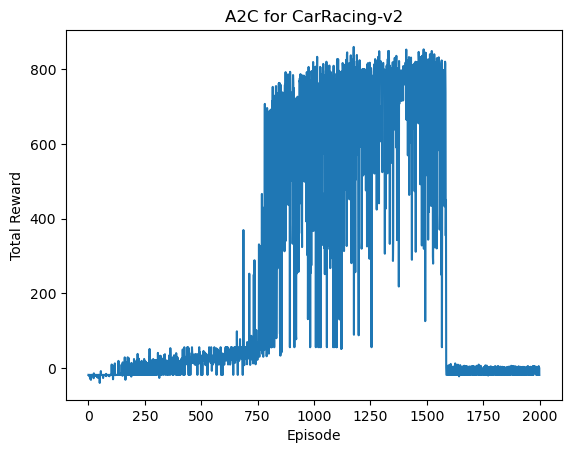

In [31]:
import matplotlib.pyplot as plt

# plot me
plt.plot(total_rewards)
plt.title('A2C for CarRacing-v2')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()